In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize

from keras.models import Model, load_model
from keras.optimizers import *
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import img_to_array, load_img

from models import create_colorizer, create_discriminator, create_GAN
from batch_generators import DiscriminatorRealGenerator, ColorizerBatchGenerator, DiscriminatorFakeGenerator
from visualizers import LossVisualizer

Using TensorFlow backend.


In [2]:
def make_trainable(layers, is_trainable):
    for l in layers:
        l.trainable = is_trainable

In [3]:
colorizer, vgg = create_colorizer()
discriminator = create_discriminator()
gan, generator_trainable_layers, discriminator_trainable_layers = create_GAN(colorizer, discriminator)

discriminator.compile( loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.01, nesterov=True) )
gan.compile( loss=['binary_crossentropy', 'mae'],  optimizer=SGD(lr=0.01, momentum=0.01, nesterov=True), loss_weights=[1.0, 5.0] )

# Train

In [4]:
# Define paths for train / validation / test datasets
train_root = '../coco/train2014/'
valid_root = '../coco/val2014/'
test_root = '../coco/test2014/'

train_image_paths = [train_root + item for item in os.listdir(train_root) if item.endswith('.jpg') ]
valid_image_paths = [valid_root + item for item in os.listdir(valid_root) if item.endswith('.jpg') ]
test_image_paths  = [test_root  + item for item in os.listdir(test_root)  if item.endswith('.jpg') ]

print( 'Train:', len(train_image_paths) )
print( 'Validation:', len(valid_image_paths) )
print( 'Test:', len(test_image_paths) )

('Train:', 82783)
('Validation:', 40504)
('Test:', 40775)


In [5]:
batch_size = 37

# Train data generators
discriminator_real_generator = DiscriminatorRealGenerator(image_paths=train_image_paths, batch_size=batch_size, image_height=224, image_width=224)
discriminator_fake_generator = DiscriminatorFakeGenerator(image_paths=train_image_paths, batch_size=batch_size, image_height=224, image_width=224)
colorizer_generator = ColorizerBatchGenerator(image_paths=train_image_paths, batch_size=batch_size, image_height=224, image_width=224)

print('There are', len(train_image_paths) / batch_size, 'steps per one train epoch for one complete cycle')
print('There are', len(valid_image_paths) / batch_size, 'steps per one validation epoch for one complete cycle')

checkpoint_path="../checkpoints/model-{epoch:03d}-{loss:.4f}.model"
model_saver = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', save_best_only=True, mode='min')
# tensorboard = TensorBoard(log_dir='/tmp/coloring/')

('There are', 2237, 'steps per one train epoch for one complete cycle')
('There are', 1094, 'steps per one validation epoch for one complete cycle')


In [ ]:
# Load models
discriminator = load_model('../checkpoints/discriminator-3.model')
colorizer = load_model('../checkpoints/colorizer-3.model')
gan = load_model('../checkpoints/gan-3.model', custom_objects={'Slice': Slice})

<IPython.core.display.Javascript object>


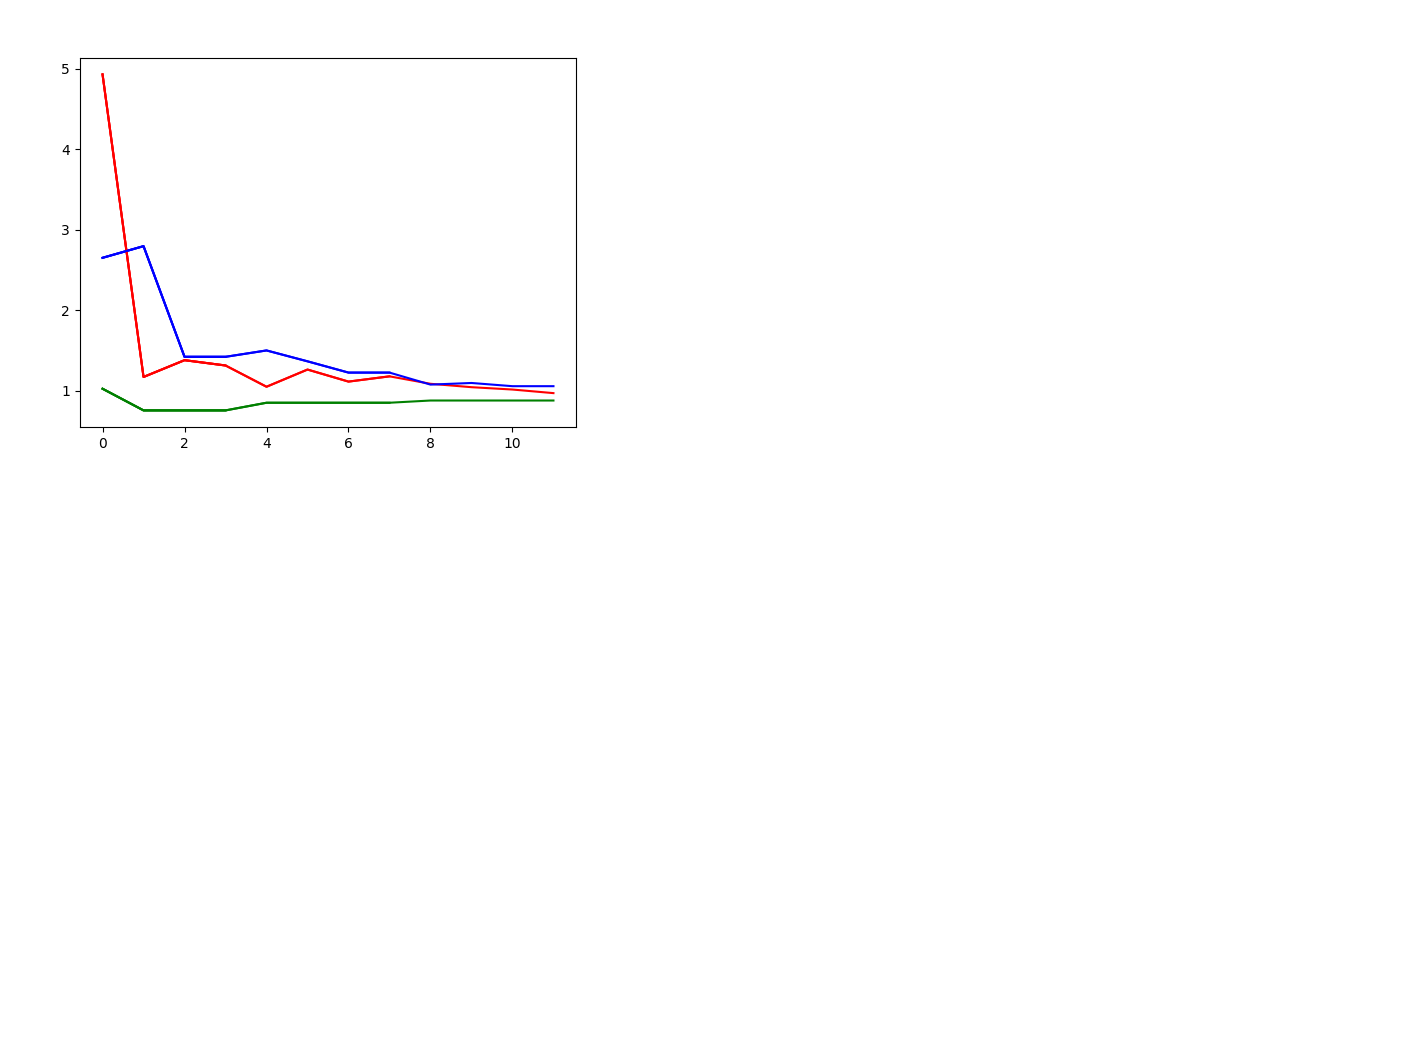

/home/martin/.miniconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook


fake_discriminator_loss = []
real_discriminator_loss = []
generator_loss = []
pattern = [0, 1, 2, 1, 2, 1, 2, 1]

epochs = 2
steps_per_epoch = 500
validation_steps = 33
# callbacks = [tensorboard, model_saver]


for epoch in range(1, epochs):
    
    steps = pattern * ( steps_per_epoch / len(pattern) )
    t = tqdm( range(len(steps)) )
    loss_visualizer = LossVisualizer()

    for i in t:
        step = steps[i]
        
        # Make discriminator better on predicting real images
        if step == 0:
            net = discriminator                                   # Propagate the data only through discriminator
            make_trainable(discriminator_trainable_layers, True)  # make discriminator layers trainable
            make_trainable(generator_trainable_layers, False)     # we don't touch the generator
            batch_generator = discriminator_real_generator        # Images are real
            net_loss = real_discriminator_loss
                
        # Make discriminator better on detecting fake images
        elif step == 1:
            net = gan                                             # Propagate the data though the whole gan
            make_trainable(discriminator_trainable_layers, True)  # Train the discriminator
            make_trainable(generator_trainable_layers, False)     # But don't touch the generator as it's not his turn
            batch_generator = discriminator_fake_generator        # Images are fake
            net_loss = fake_discriminator_loss
        
        # Make colorizer better in fooling the discriminator
        else:
            net = gan                                             # Propagate the data through the whole gan
            make_trainable(discriminator_trainable_layers, False) # Don't train the discriminator when fooling it
            make_trainable(generator_trainable_layers, True)      # Train only the generator
            batch_generator = colorizer_generator                 # Lets fool the discriminator
            net_loss = generator_loss

        
        # Train on the current batch
        batch = batch_generator.next()
        if len(batch) == 2:
            inputs, labels = batch
            loss = net.train_on_batch(inputs, labels)
        else:
            inputs, labels, image_labels = batch
            loss = net.train_on_batch(inputs, [labels, image_labels])[1]
        net_loss.append(loss)
        
        
        # Plot the loss graph
        if i % len(pattern) == 0:
            loss_visualizer.plot(fake_discriminator_loss, real_discriminator_loss, generator_loss)
        
        # Display progress
        t.set_description('Train batch %i' % i)
        t.set_postfix(loss=loss, step=step)
    
    # Save model checkpoints
    gan.save('../checkpoints/gan-' + str(epoch) + '.model')
    colorizer.save('../checkpoints/colorizer-' + str(epoch) + '.model')
    discriminator.save('../checkpoints/discriminator-' + str(epoch) + '.model')
    
    # Clear loss lists to prepare for the next epoch
    del fake_discriminator_loss[:]
    del real_discriminator_loss[:]
    del generator_loss[:]

# Evaluate

In [ ]:
%matplotlib inline

path = './puma.jpg'                                          # random.choice(test_image_paths)
inp, _ = colorizer_generator.generate_one(path)              # get input for generator

out = colorizer.predict(np.array([inp]), batch_size=1)[0]    # make a prediction and get a,b channels scaled to (-1;1)

rgb = resize( io.imread(path), output_shape=(224, 224, 3) )  # resize the image to display it later on
img = np.zeros((224, 224, 3))                                # image that we are displaying has 224x224 size
img[...,0] = color.rgb2lab(rgb)[...,0]                       # first channel is the lightness of the image
img[...,1:] = out * 128.                                     # a,b channels are scaled to [-128;128]

print(out.shape)
plt.imshow(color.lab2rgb(img))

# Experiments

In [ ]:
for i in range(len(out)):
    for j in out[i]:
        if j[0] != j[1]:
            print( j[0], j[1] )

In [ ]:
img[77][23]